# **Changellenge>> Cup IT 2022 Data Science**
# **Финал**

# Team: *One_Zero*

##### Задача: 

Обучить модель определять, кто из участников программы лояльности похож на покупателей, присоединившихся к Клубу Полезных *Привычек*

На выходе необходимо получить ранжированный список покупателей с прогнозом о потенциале присоединения к клубу и вариантом дальнейшего взаимодействия

##### Описание данных

Данные представляют помесячно агрегированные сведения о покупках участников программы лояльности перекрёстка с флагом участия в клубе в .csv формате

Основные данные:
* client_id - уникальный идентификатор клиента, число от 0 до X    
* rto_n - сумма товарооборота клиента в месяц    
* rto_n_category - сумма товарооборота клиента в месяц в определенной категории    
* rto_std_n - стандартное отклонение суммы товарооборота от чека к чеку в месяц    
* rto_std_n_category - стандартное отклонение суммы товарооборота от чека к чеку в месяц в определенной категории
* cnt_checks_n - количество уникальных чеков клиента в месяц    
* cnt_checks_n_category - Количество уникальных чеков клиента в месяц в определенной категории    
* is_in_club - флаг участия в клубе

Дополнительные данные:
* index - уникальный идентификатор клиента, совпадает с client_id
* cnt_unique_plu_n - количество уникальных товаров (plu), купленных клиентом в месяц n
* cnt_unique_plu_n_category - количество уникальных товаров (plu), купленных клиентом в месяц n в категории category

## Импорт модулей и библиотек

In [1]:
pip install hypertools

     |████████████████████████████████| 59 kB 4.5 MB/s 
     |████████████████████████████████| 86 kB 5.3 MB/s 
     |████████████████████████████████| 1.1 MB 55.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=fef97cacdd96a248124ddb1f332f6dc09bae7684f8cf54e7e4fa118382994a89
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=1ffb0c54b6eed3866b9a4cef89877cbc6df1e48479b616dfe57f366ff243a1c3
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


In [2]:
pip install gdown

In [3]:
pip install --upgrade --no-cache-dir gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=2033d7059d661bd6e23e5f3927bf11504ee53b82b66daad848851ee52abde4d6
  Stored in directory: /tmp/pip-ephem-wheel-cache-23u8z7rt/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.2
    Uninstalling gdown-4.2.2:
      Successfully uninstalled gdown-4.2.2


In [4]:
pip install shap

     |████████████████████████████████| 564 kB 6.9 MB/s 


In [5]:
import gdown

import warnings
warnings.filterwarnings('ignore')

import time
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import hypertools as hyp
import shap
import matplotlib
from matplotlib import pyplot as plt
import pylab

import pickle 

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif, chi2
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, f1_score, accuracy_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans

from lightgbm import LGBMClassifier

%config Completer.use_jedi = False
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
pd.set_option('display.max_columns', None)

## Загрузка данных

Скачаем данные с гугл.диска

In [7]:
!gdown --id 1fX92uuwq08bO6bhx-tcIUR9yk9FlXOMo
!gdown --id 1w03BvehdR-hoXu0xU9RY1jGciF4UdQpm

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1fX92uuwq08bO6bhx-tcIUR9yk9FlXOMo
To: /content/Cup_IT_2022_Data_Science_dataset_final.csv
100% 123M/123M [00:01<00:00, 70.0MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1w03BvehdR-hoXu0xU9RY1jGciF4UdQpm
To: /content/Cup_IT_2022_Data_Science_additional_data.csv
100% 18.4M/18.4M [00:00<00:00, 55.8MB/s]


Подгрузим основной набор данных в ноутбук

In [8]:
data = pd.read_csv('Cup_IT_2022_Data_Science_dataset_final.csv', index_col=0)

data.shape

(135061, 148)

Подгрузим дополнительный набор данных в ноутбук

In [9]:
data_additional = pd.read_csv('Cup_IT_2022_Data_Science_additional_data.csv', index_col=0)

data_additional.shape

(135061, 50)

In [10]:
data_additional.rename(columns={"index": "client_id"}, inplace=True)

Объединяем оба набора в один

In [11]:
data = data.merge(data_additional, on="client_id")

In [12]:
data.set_index('client_id', inplace=True)

## Анализ и предобработка данных

В первую очередь необходимо посмотреть на данные и выявить особенности, требующие дальшей обработки

Посмотрим на данные

In [13]:
data.sample(5)

,is_in_club,cnt_checks_10_Мясная гастрономия,rto_std_11,rto_6,rto_12_Сыры,rto_12_Птица и изделия из птицы,rto_8,cnt_checks_9,rto_9_Мясная гастрономия,rto_10_Птица и изделия из птицы,cnt_checks_9_Рыба и рыбные изделия,rto_stddev_6_Рыба и рыбные изделия,rto_12_Мясная гастрономия,rto_stddev_8_Крупы и зерновые,rto_12,rto_6_Птица и изделия из птицы,rto_6_Рыба и рыбные изделия,cnt_checks_11,rto_stddev_7_Птица и изделия из птицы,rto_stddev_9_Сыры,cnt_checks_10_Овощи - Фрукты,cnt_checks_12_Птица и изделия из птицы,rto_6_Мясная гастрономия,rto_stddev_6_Овощи - Фрукты,cnt_checks_6_Мясная гастрономия,rto_stddev_6_Мясная гастрономия,cnt_checks_11_Сыры,cnt_checks_12_Овощи - Фрукты,rto_stddev_10_Птица и изделия из птицы,cnt_checks_6_Сыры,rto_stddev_10_Овощи - Фрукты,rto_12_Крупы и зерновые,rto_7_Птица и изделия из птицы,cnt_checks_12_Рыба и рыбные изделия,rto_stddev_10_Крупы и зерновые,rto_7_Крупы и зерновые,rto_7_Овощи - Фрукты,cnt_checks_10_Птица и изделия из птицы,rto_9_Рыба и рыбные изделия,cnt_checks_11_Крупы и зерновые,rto_stddev_11_Крупы и зерновые,rto_stddev_6_Крупы и зерновые,rto_stddev_12_Овощи - Фрукты,cnt_checks_11_Рыба и рыбные изделия,rto_stddev_9_Крупы и зерновые,rto_11_Крупы и зерновые,rto_stddev_10_Сыры,cnt_checks_12_Мясная гастрономия,rto_stddev_10_Мясная гастрономия,rto_stddev_8_Рыба и рыбные изделия,cnt_checks_9_Крупы и зерновые,rto_10_Сыры,rto_stddev_6_Сыры,cnt_checks_7_Сыры,cnt_checks_6_Птица и изделия из птицы,cnt_checks_6_Рыба и рыбные изделия,rto_8_Овощи - Фрукты,cnt_checks_10_Крупы и зерновые,rto_12_Овощи - Фрукты,rto_11_Мясная гастрономия,cnt_checks_12_Крупы и зерновые,rto_stddev_11_Мясная гастрономия,rto_stddev_12_Птица и изделия из птицы,rto_stddev_7_Крупы и зерновые,cnt_checks_6,cnt_checks_9_Овощи - Фрукты,cnt_checks_7_Крупы и зерновые,cnt_checks_8_Птица и изделия из птицы,rto_11_Птица и изделия из птицы,rto_stddev_11_Сыры,cnt_checks_7_Птица и изделия из птицы,rto_10_Овощи - Фрукты,rto_stddev_7_Мясная гастрономия,rto_9_Сыры,rto_10_Мясная гастрономия,rto_stddev_12_Рыба и рыбные изделия,cnt_checks_7,rto_7_Мясная гастрономия,cnt_checks_9_Мясная гастрономия,cnt_checks_7_Мясная гастрономия,rto_9_Овощи - Фрукты,rto_stddev_9_Птица и изделия из птицы,rto_std_9,rto_stddev_10_Рыба и рыбные изделия,rto_stddev_9_Рыба и рыбные изделия,cnt_checks_9_Сыры,rto_stddev_6_Птица и изделия из птицы,rto_10_Рыба и рыбные изделия,rto_12_Рыба и рыбные изделия,rto_10_Крупы и зерновые,cnt_checks_12,cnt_checks_10_Рыба и рыбные изделия,rto_stddev_9_Овощи - Фрукты,rto_11_Рыба и рыбные изделия,rto_6_Овощи - Фрукты,cnt_checks_10,rto_stddev_7_Овощи - Фрукты,cnt_checks_12_Сыры,rto_std_7,cnt_checks_8_Овощи - Фрукты,rto_stddev_8_Мясная гастрономия,rto_stddev_11_Овощи - Фрукты,cnt_checks_7_Овощи - Фрукты,rto_9_Птица и изделия из птицы,cnt_checks_6_Крупы и зерновые,cnt_checks_8_Крупы и зерновые,cnt_checks_7_Рыба и рыбные изделия,cnt_checks_11_Овощи - Фрукты,cnt_checks_8_Рыба и рыбные изделия,cnt_checks_11_Мясная гастрономия,rto_8_Мясная гастрономия,rto_10,rto_std_8,rto_stddev_11_Птица и изделия из птицы,rto_stddev_8_Птица и изделия из птицы,rto_stddev_12_Мясная гастрономия,rto_6_Сыры,rto_7,rto_std_6,cnt_checks_9_Птица и изделия из птицы,rto_stddev_11_Рыба и рыбные изделия,rto_9,rto_std_10,rto_stddev_8_Сыры,rto_8_Птица и изделия из птицы,rto_11_Овощи - Фрукты,cnt_checks_11_Птица и изделия из птицы,rto_7_Рыба и рыбные изделия,cnt_checks_6_Овощи - Фрукты,rto_9_Крупы и зерновые,rto_7_Сыры,rto_8_Крупы и зерновые,cnt_checks_8_Мясная гастрономия,rto_stddev_7_Сыры,rto_8_Сыры,rto_11,rto_std_12,cnt_checks_10_Сыры,rto_stddev_12_Сыры,rto_6_Крупы и зерновые,rto_stddev_7_Рыба и рыбные изделия,rto_stddev_8_Овощи - Фрукты,rto_8_Рыба и рыбные изделия,rto_11_Сыры,cnt_checks_8_Сыры,cnt_checks_8,rto_stddev_9_Мясная гастрономия,rto_stddev_12_Крупы и зерновые,cnt_unique_plu_6,cnt_unique_plu_7,cnt_unique_plu_8,cnt_unique_plu_9,cnt_unique_plu_10,cnt_unique_plu_11,cnt_unique_plu_12,cnt_unique_plu_10_Мясная гастрономия,cnt_unique_plu_10_Овощи - Фрукты,cnt_unique_plu_10_Птица

При первом приближении можно заметить большое количество NaN-значений и разреженность данных

Посмотрим на количество  клиентов, которые уже состоят и не состоят в Клубе Полезных Привычек Перекрестка

In [14]:
len(data.loc[data['is_in_club'] == 1])

12418

In [15]:
len(data.loc[data['is_in_club'] == 0])

122643

**На этапе обучения нам понадобится обработка дисбаланса**

##### Теперь проанализируем, какой процент клиентов приобретал товары определенной категории за каждый месяц и выявим наиболее популярные

Посмотрим на значения, отличные от NaN

In [16]:
#Вычитаем из 100 процентов, чтобы понять, сколько значений, отличных от Nan
nans = dict(round(100-(data.isna().mean()*100)))
nans

{'cnt_checks_10': 95.0,
 'cnt_checks_10_Крупы и зерновые': 24.0,
 'cnt_checks_10_Мясная гастрономия': 49.0,
 'cnt_checks_10_Овощи - Фрукты': 73.0,
 'cnt_checks_10_Птица и изделия из птицы': 38.0,
 'cnt_checks_10_Рыба и рыбные изделия': 7.0,
 'cnt_checks_10_Сыры': 52.0,
 'cnt_checks_11': 93.0,
 'cnt_checks_11_Крупы и зерновые': 24.0,
 'cnt_checks_11_Мясная гастрономия': 48.0,
 'cnt_checks_11_Овощи - Фрукты': 73.0,
 'cnt_checks_11_Птица и изделия из птицы': 38.0,
 'cnt_checks_11_Рыба и рыбные изделия': 7.0,
 'cnt_checks_11_Сыры': 51.0,
 'cnt_checks_12': 93.0,
 'cnt_checks_12_Крупы и зерновые': 22.0,
 'cnt_checks_12_Мясная гастрономия': 50.0,
 'cnt_checks_12_Овощи - Фрукты': 75.0,
 'cnt_checks_12_Птица и изделия из птицы': 38.0,
 'cnt_checks_12_Рыба и рыбные изделия': 8.0,
 'cnt_checks_12_Сыры': 53.0,
 'cnt_checks_6': 87.0,
 'cnt_checks_6_Крупы и зерновые': 18.0,
 'cnt_checks_6_Мясная гастрономия': 43.0,
 'cnt_checks_6_Овощи - Фрукты': 67.0,
 'cnt_checks_6_Птица и изделия из птицы': 33.0,

In [17]:
monthly_products = {6:[], 7:[], 8:[], 9:[], 10:[], 11:[], 12:[]}
monthly_popularity = {6:[], 7:[], 8:[], 9:[], 10:[], 11:[], 12:[]}

for key in nans.keys():
    for i in range(6, 13):
        if key.find(f'cnt_checks_{i}_') != -1:
            monthly_products[i].append((key.split(f'{i}_')[1]))
            monthly_popularity[i].append(nans[key])

Построим график популярности разных категорий товаров у участников клубов

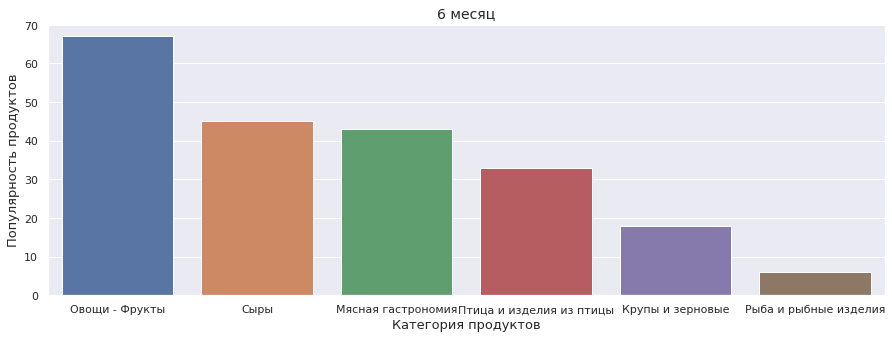

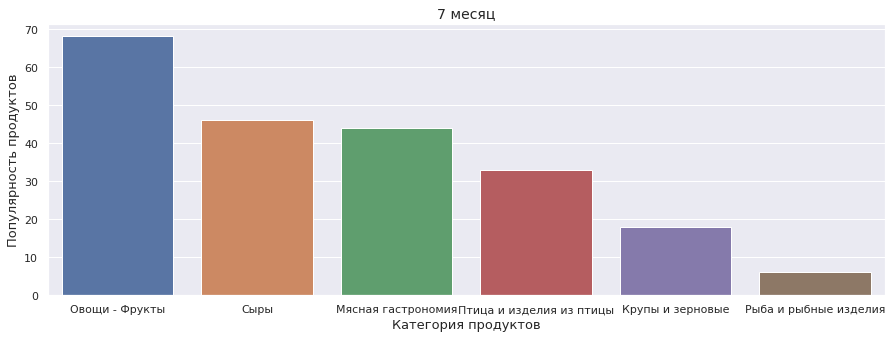

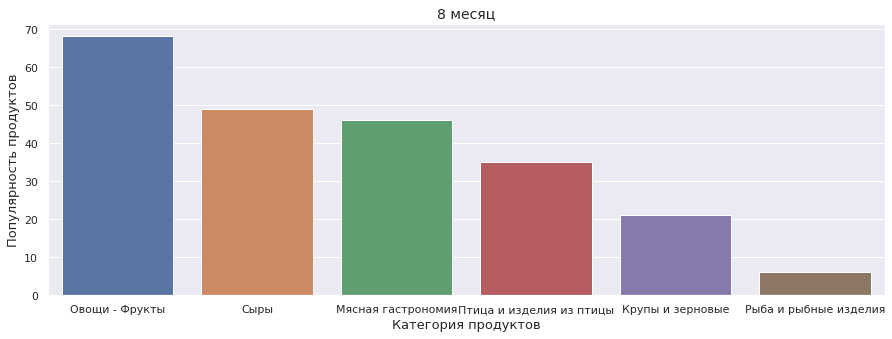

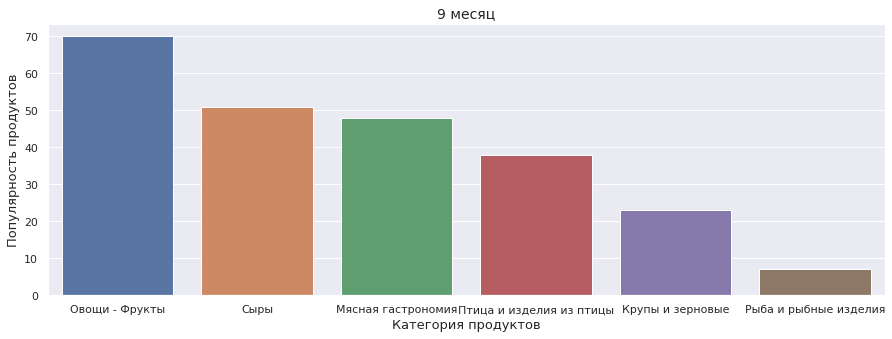

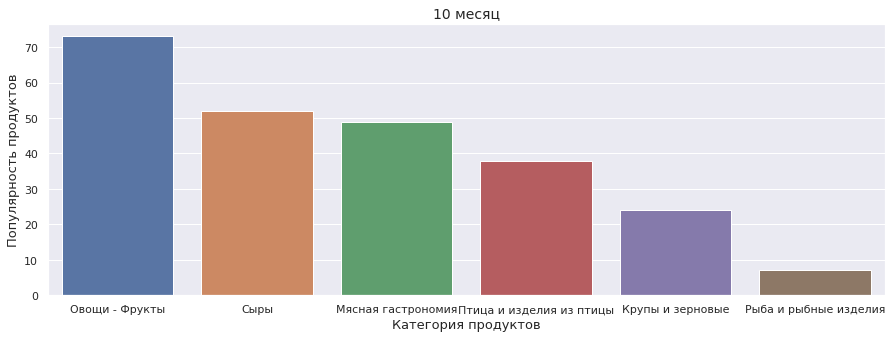

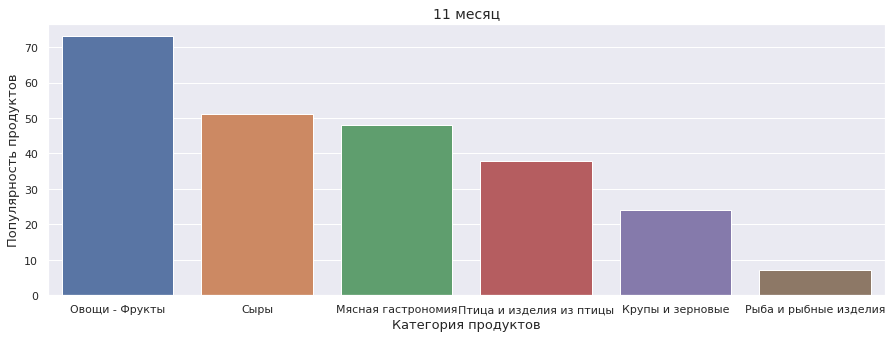

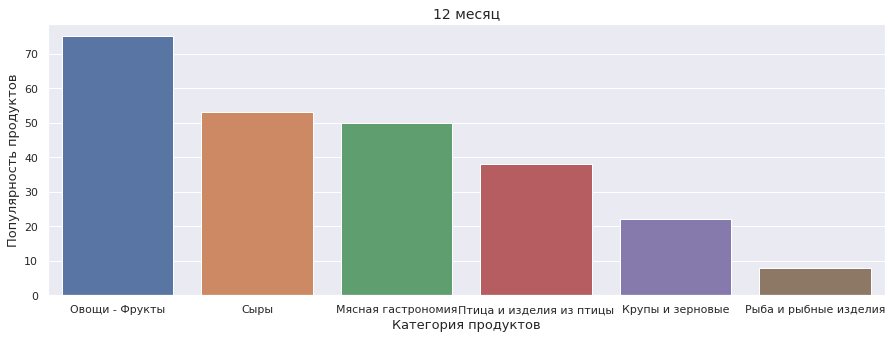

In [18]:
for i in range(6, 13):
    
    sns.set(rc={'figure.figsize':(15,5)})
    data_club = pd.DataFrame(list(zip(monthly_products[i], monthly_popularity[i])))
    data_club.sort_values(by=1, ascending=False, inplace=True)
    sns.barplot(x=0, y=1, ci = None, data=data_club);
    
    plt.xlabel('Категория продуктов', fontsize=13) # добавляем название оси Ох
    plt.ylabel('Популярность продуктов', fontsize=13) # добавляем название оси Оу
    plt.title(f'{i} месяц', fontsize=14) # добавляем название графику
    
    plt.show()

In [19]:
df_popularity=pd.DataFrame(list(zip(monthly_products[6], monthly_popularity[6])))

In [20]:
df_popularity

,0,1
0,Мясная гастрономия,43.0
1,Сыры,45.0
2,Птица и изделия из птицы,33.0
3,Рыба и рыбные изделия,6.0
4,Крупы и зерновые,18.0
5,Овощи - Фрукты,67.0


По полученному графику можно заметить следующее: соотношение вкусов покупателей и общий объем популярности категорий практически не меняются от месяца к месяцу

**В датафрейме присутствуют зависимые признаки, следовательно, стоит провести их обработку, чтобы избежать переобучения модели**

##### Перед обработкой фич немного поправим данные

Заменим все NaN на 0, поскольку это означает, что не было покупок в этой категории/месяце:

In [21]:
data = data.fillna(0)

Проверим дубли

In [22]:
data.duplicated().sum() # повторов нет

0

Еще раз посмотрим на данные

In [23]:
data.describe()

,is_in_club,cnt_checks_10_Мясная гастрономия,rto_std_11,rto_6,rto_12_Сыры,rto_12_Птица и изделия из птицы,rto_8,cnt_checks_9,rto_9_Мясная гастрономия,rto_10_Птица и изделия из птицы,cnt_checks_9_Рыба и рыбные изделия,rto_stddev_6_Рыба и рыбные изделия,rto_12_Мясная гастрономия,rto_stddev_8_Крупы и зерновые,rto_12,rto_6_Птица и изделия из птицы,rto_6_Рыба и рыбные изделия,cnt_checks_11,rto_stddev_7_Птица и изделия из птицы,rto_stddev_9_Сыры,cnt_checks_10_Овощи - Фрукты,cnt_checks_12_Птица и изделия из птицы,rto_6_Мясная гастрономия,rto_stddev_6_Овощи - Фрукты,cnt_checks_6_Мясная гастрономия,rto_stddev_6_Мясная гастрономия,cnt_checks_11_Сыры,cnt_checks_12_Овощи - Фрукты,rto_stddev_10_Птица и изделия из птицы,cnt_checks_6_Сыры,rto_stddev_10_Овощи - Фрукты,rto_12_Крупы и зерновые,rto_7_Птица и изделия из птицы,cnt_checks_12_Рыба и рыбные изделия,rto_stddev_10_Крупы и зерновые,rto_7_Крупы и зерновые,rto_7_Овощи - Фрукты,cnt_checks_10_Птица и изделия из птицы,rto_9_Рыба и рыбные изделия,cnt_checks_11_Крупы и зерновые,rto_stddev_11_Крупы и зерновые,rto_stddev_6_Крупы и зерновые,rto_stddev_12_Овощи - Фрукты,cnt_checks_11_Рыба и рыбные изделия,rto_stddev_9_Крупы и зерновые,rto_11_Крупы и зерновые,rto_stddev_10_Сыры,cnt_checks_12_Мясная гастрономия,rto_stddev_10_Мясная гастрономия,rto_stddev_8_Рыба и рыбные изделия,cnt_checks_9_Крупы и зерновые,rto_10_Сыры,rto_stddev_6_Сыры,cnt_checks_7_Сыры,cnt_checks_6_Птица и изделия из птицы,cnt_checks_6_Рыба и рыбные изделия,rto_8_Овощи - Фрукты,cnt_checks_10_Крупы и зерновые,rto_12_Овощи - Фрукты,rto_11_Мясная гастрономия,cnt_checks_12_Крупы и зерновые,rto_stddev_11_Мясная гастрономия,rto_stddev_12_Птица и изделия из птицы,rto_stddev_7_Крупы и зерновые,cnt_checks_6,cnt_checks_9_Овощи - Фрукты,cnt_checks_7_Крупы и зерновые,cnt_checks_8_Птица и изделия из птицы,rto_11_Птица и изделия из птицы,rto_stddev_11_Сыры,cnt_checks_7_Птица и изделия из птицы,rto_10_Овощи - Фрукты,rto_stddev_7_Мясная гастрономия,rto_9_Сыры,rto_10_Мясная гастрономия,rto_stddev_12_Рыба и рыбные изделия,cnt_checks_7,rto_7_Мясная гастрономия,cnt_checks_9_Мясная гастрономия,cnt_checks_7_Мясная гастрономия,rto_9_Овощи - Фрукты,rto_stddev_9_Птица и изделия из птицы,rto_std_9,rto_stddev_10_Рыба и рыбные изделия,rto_stddev_9_Рыба и рыбные изделия,cnt_checks_9_Сыры,rto_stddev_6_Птица и изделия из птицы,rto_10_Рыба и рыбные изделия,rto_12_Рыба и рыбные изделия,rto_10_Крупы и зерновые,cnt_checks_12,cnt_checks_10_Рыба и рыбные изделия,rto_stddev_9_Овощи - Фрукты,rto_11_Рыба и рыбные изделия,rto_6_Овощи - Фрукты,cnt_checks_10,rto_stddev_7_Овощи - Фрукты,cnt_checks_12_Сыры,rto_std_7,cnt_checks_8_Овощи - Фрукты,rto_stddev_8_Мясная гастрономия,rto_stddev_11_Овощи - Фрукты,cnt_checks_7_Овощи - Фрукты,rto_9_Птица и изделия из птицы,cnt_checks_6_Крупы и зерновые,cnt_checks_8_Крупы и зерновые,cnt_checks_7_Рыба и рыбные изделия,cnt_checks_11_Овощи - Фрукты,cnt_checks_8_Рыба и рыбные изделия,cnt_checks_11_Мясная гастрономия,rto_8_Мясная гастрономия,rto_10,rto_std_8,rto_stddev_11_Птица и изделия из птицы,rto_stddev_8_Птица и изделия из птицы,rto_stddev_12_Мясная гастрономия,rto_6_Сыры,rto_7,rto_std_6,cnt_checks_9_Птица и изделия из птицы,rto_stddev_11_Рыба и рыбные изделия,rto_9,rto_std_10,rto_stddev_8_Сыры,rto_8_Птица и изделия из птицы,rto_11_Овощи - Фрукты,cnt_checks_11_Птица и изделия из птицы,rto_7_Рыба и рыбные изделия,cnt_checks_6_Овощи - Фрукты,rto_9_Крупы и зерновые,rto_7_Сыры,rto_8_Крупы и зерновые,cnt_checks_8_Мясная гастрономия,rto_stddev_7_Сыры,rto_8_Сыры,rto_11,rto_std_12,cnt_checks_10_Сыры,rto_stddev_12_Сыры,rto_6_Крупы и зерновые,rto_stddev_7_Рыба и рыбные изделия,rto_stddev_8_Овощи - Фрукты,rto_8_Рыба и рыбные изделия,rto_11_Сыры,cnt_checks_8_Сыры,cnt_checks_8,rto_stddev_9_Мясная гастрономия,rto_stddev_12_Крупы и зерновые,cnt_unique_plu_6,cnt_unique_plu_7,cnt_unique_plu_8,cnt_unique_plu_9,cnt_unique_plu_10,cnt_unique_plu_11,cnt_unique_plu_12,cnt_unique_plu_10_Мясная гастрономия,cnt_unique_plu_10_Овощи - Фрукты,cnt_unique_plu_10_Птица

Можно заметить строки с отрицательными значениями в колонках, где их быть не должно, проанализируем количество строк с такими значениями и распределение "ошибок" среди групп покупателей

In [24]:
(data.lt(0).sum()).sum() #количество отрицательных значений в наборе данных

14347

In [25]:
data.shape[0] - data[(data >= 0).all(1)].shape[0] # количество строк с отрицательными значениями

13003

In [26]:
df_neg = data[~(data >= 0).all(1)] # датафрейм с отрицательными значениями

Также посмотрим на количество отрицательных значений среди участников клуба

In [27]:
df_neg[df_neg['is_in_club'] == 1].shape[0] # 1491 из 12418 участников клуба

1491

Строки с отрицательными значениями составляют 10% от общего датасета, а также в этих строках примерно сохраняется соотношение 1 и 0 в 'is_in_club'

На наш взгляд, имеющиеся отрицательные значения (после обработки) не грозят снижением качества предсказаний модели, но и знаительной дополнительной информации они не дадут, поскольку неинтерпритируемы и сама доля таких значений относительно общего объема данных (по строкам и столбцам) незначитльно мала

Все это говорит о том, что эти данные скорее шум, чем потенциальный паттерн определения участников клуба

**Поэтому мы обработаем эти строки ниже как шум, перезаполним и будем использовать их для обучения вместе с 'нормальными' данными**

## На этапе анализа мы выявили следующие основные особенности данных, требующие дополнительного внимания:

1.   Дисбаланс классов
2.   Шум в данных (выбросы, отрицательные значения)
3.   Шум в фичах (взаимная корреляция, потенциальные малозначимые признаки)

## Обработка фич

Поскольку в нашем наборе имеется большое количество дублирующихся по смыслу фич, имеет смысл постараться уменьшить размерность данных, например, за счет создания новых на основе нескольких старых

Выделим два новых признака:


1) Доля стоимости товарооборота здоровых продуктов во всей сумме

In [28]:
features = data.columns

In [29]:
def new_feature(data, prefix):
    for month in range(6,13):
        healthy = []
        for feature in features:
            if feature.find(f'{prefix}{month}_') != -1: # найдём названия столбцов по категории
                healthy.append(feature)
            data[f'{prefix}healthy_{month}'] = data[healthy].sum(axis=1)/data[f'{prefix}{month}'] # рассчитаем долю
        data.drop(healthy, axis=1, inplace=True) # удалим суммы по категориям, доля выведена из этих данных и концентрирует их в себе
    return data.fillna(0)

In [30]:
data = new_feature(data, prefix='rto_')

2) Доля чеков здоровых продуктов во всех уникальных чеках клиента в месяц



In [31]:
data = new_feature(data, prefix='cnt_checks_')

In [32]:
data.shape

(135061, 127)

**В итоге стало на 21 фичу меньше изначального количества, такая операция в итоге оказала положительное влияние на метрики**

На этом работа с фичами не заканчивается, чтобы избежать утечки информации, мы продолжим обработку фич с использованием статистической оценки после разделения данных на тренирочные и тестовые

## Разделение данных на обучающую и тестовые выборки

In [33]:
X = data.drop('is_in_club', 1)
y = data['is_in_club']

Посмотрим соотношение классов до разбиения

In [34]:
print('is_in_club = 1: {:.2f}\nis_in_club = 0: {:.2f}'.format(sum(y)/float(len(y)), 1.0 - sum(y)/float(len(y))))

is_in_club = 1: 0.09
is_in_club = 0: 0.91


In [35]:
train_data, test_data, train_labels, test_labels = train_test_split(X, y, train_size=0.7, random_state=42, shuffle=False)
print(train_data.shape, test_data.shape)

(94542, 126) (40519, 126)


Теперь посмотрим на баланс соотношения данных в трейновой и тестовой выборках

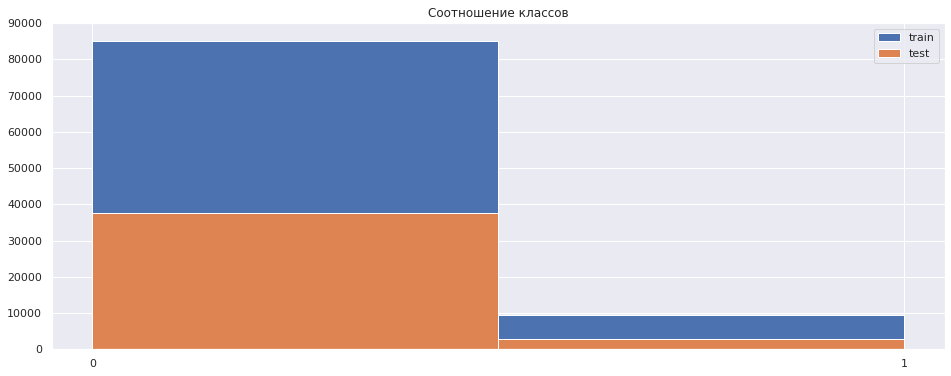

In [36]:
pylab.figure(figsize = (16, 6))
pylab.ylim([0, 90000])
pylab.hist(train_labels, bins=2)
pylab.hist(test_labels, bins=2)
pylab.xticks([0, 1])
pylab.title('Соотношение классов')
pylab.legend(['train', 'test'])

**Общий баланс соотношения классов сохранился после разбиения**

## Дообработка данных (+ гипотезы)

Все дальнейшие преобразования, касающиеся статистической оценки данных, мы будем производить, не смешивая их

**Наша первая гипотеза - обработка шума в данных повысит качество работы модели**

Под шумом мы понимаем как несвойственные для выборки экстримальные значения, так и 'ошибочные' данные - отрицательные значения

**Наша вторая гипотеза - обработка шума в признаках повысит качество работы модели**

Здесь под шумом мы понимаем однотипные признаки с высокой взаимной корреляцией, а также просто малозначимые фичи

### Обработка отрицательных значений [гипотеза 1]

Раздельно заполним отрицательные значения

In [37]:
# мы ещё пробовали IterativeImputer, но результат был практически аналогичный

train_data[train_data < 0] = np.NaN
test_data[test_data < 0] = np.NaN

train_data = pd.DataFrame(SimpleImputer(missing_values=np.NaN, strategy='most_frequent').fit_transform(train_data), columns=train_data.columns)
test_data = pd.DataFrame(SimpleImputer(missing_values=np.NaN, strategy='most_frequent').fit_transform(test_data), columns=test_data.columns)

**Несмотря на малозначительную прибавку (но всё же прибавку) в метриках в изоляции после этого этапа, было важно протестировать этот вариант**

Такой результат (небольшая прибавка) мы связывем с тем, что количество отрицательных значений относительно общего объема невелико + выбранная модель хорошо справляется с ними по умолчанию

### Обработка аномалий [гипотеза 1]

In [38]:
# для удобства дальнейшей обработки объедим тренировочные данные и лейблы
# сами лейблы нам не понадобятся
df_train = train_data 

df_train['is_in_club'] = train_labels

Посмотрим на столбцы: сумма товарооборота клиента в месяц (rto_n) и стандартное отклонение суммы товарооборота от чека к чеку в месяц (rto_std_n)

In [39]:
col_rto = []
for column in df_train.columns:
    for i in range(6, 13):
        if column.find(f'rto_{i}') != -1:
            col_rto.append(f'rto_{i}')

In [40]:
col_rto_std = []
for column in df_train.columns:
    for i in range(6, 13):
        if column.find(f'rto_std_{i}') != -1:
            col_rto_std.append(f'rto_std_{i}')

<AxesSubplot:>

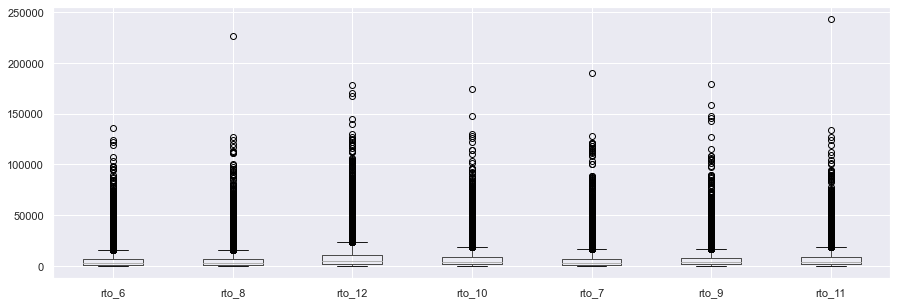

In [ ]:
df_train[col_rto].boxplot()

<AxesSubplot:>

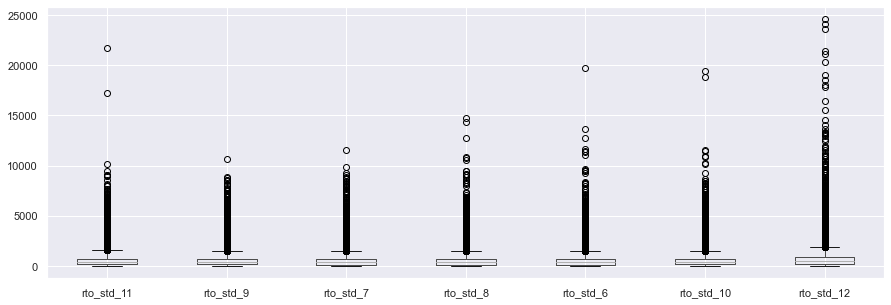

In [ ]:
df_train[col_rto_std].boxplot()

In [ ]:
df_train.shape

(94542, 127)

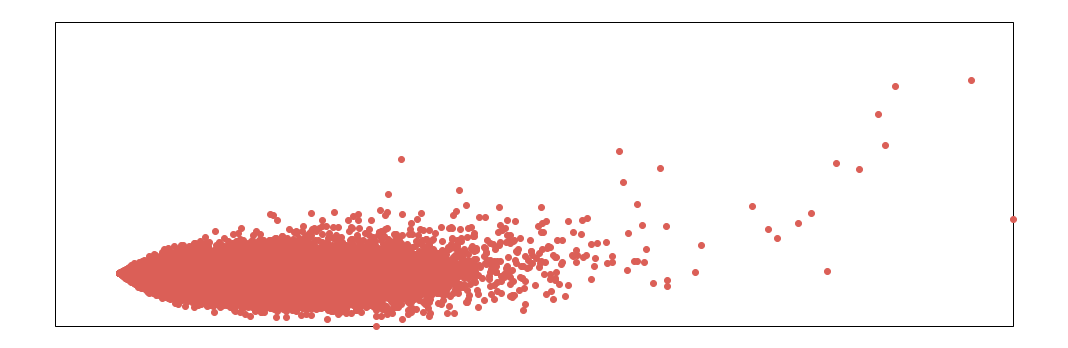

In [ ]:
hyp.plot(df_train.drop('is_in_club', 1), normalize='across', reduce='PCA', ndims=2, fmt='o')

По обоим графикам можно заметить, что у нас присутствуют нетипичные точки, которые могут негативно повлиять на прогноз

Для unsupervised удаления аномалий в достаточно многомерных данных хорошо подойдут Local Outlier Factor и One Class SVM

Референс: https://scikit-learn.org/stable/modules/outlier_detection.html#novelty-and-outlier-detection

Local Outlier Factor - это метод неконтролируемого обнаружения аномалий, который вычисляет локальное отклонение плотности каждой точки данных по отношению к ее соседям. Он считает выбросами образцы, которые имеют значительно меньшую плотность, чем их соседи


In [41]:
outliers_lof = LocalOutlierFactor(algorithm='auto', contamination=0.01).fit_predict(df_train.drop('is_in_club', 1))
train_data_lof = train_data[outliers_lof != -1] # выбираем все данные, не являющиеся выбросами

<AxesSubplot:>

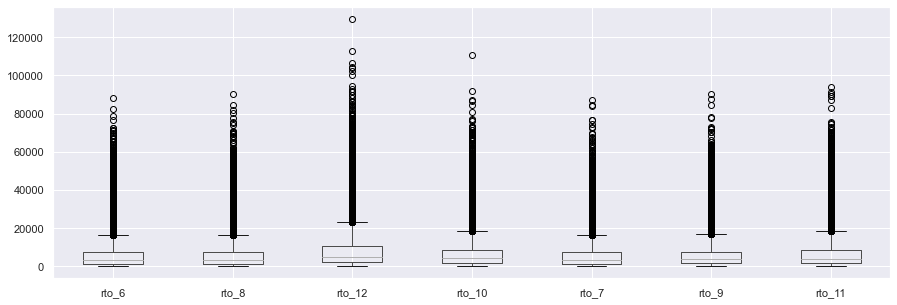

In [ ]:
train_data_lof[col_rto].boxplot()

<AxesSubplot:>

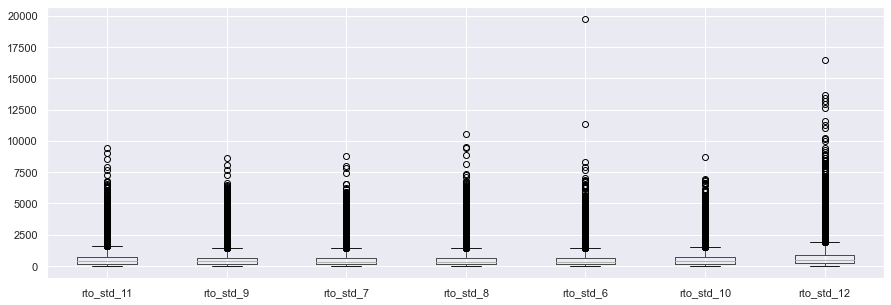

In [ ]:
train_data_lof[col_rto_std].boxplot()

One Class SVM в отличие от обычного SVM, не имеет целевого лейбла для обучения. Вместо этого OCSVM анализирует границы нормальных данных и определяет выходящие из них точки аномалиями

In [42]:
outliers = OneClassSVM(nu=0.01).fit_predict(df_train.drop('is_in_club', 1)) # выбираем нужный процент аномалий
train_data_svm = train_data[outliers != -1] # выбираем все данные, не являющиеся выбросами

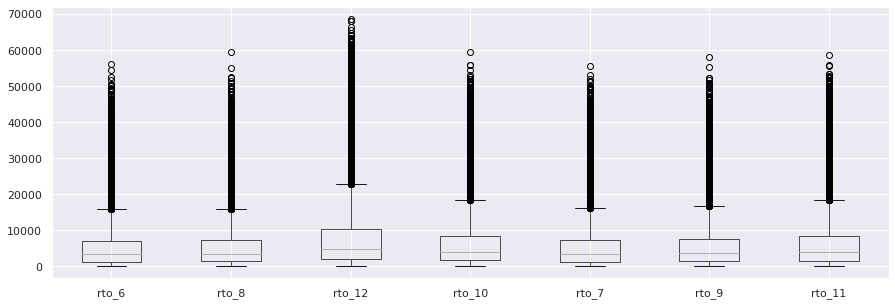

In [43]:
train_data_svm[col_rto].boxplot()

<AxesSubplot:>

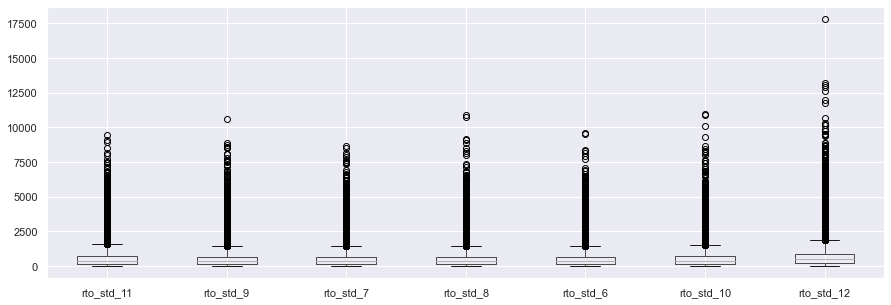

In [ ]:
train_data_svm[col_rto_std].boxplot()

In [ ]:
train_data_lof['rto_6'].describe()

count    93596.000000
mean      5261.797456
std       6179.705780
min          0.000000
25%       1188.239257
50%       3281.126650
75%       7126.333639
max      87964.226085
Name: rto_6, dtype: float64

In [ ]:
train_data_svm['rto_6'].describe()

count    93594.000000
mean      5153.199447
std       5784.430053
min          0.000000
25%       1186.123612
50%       3272.869355
75%       7083.052381
max      56163.763945
Name: rto_6, dtype: float64

In [ ]:
train_data_lof.shape

(93596, 127)

In [ ]:
train_data_svm.shape

(93594, 127)

Граница в 1% выбросов даёт ощутимый прирост в качестве, дальнейшие изменения не дают прироста в метриках, либо снижают их

Можно заметить, что после ocSVM std в данных значительно (в отличие от квантилей и среднего) уменьшилось

В отличие от ocSVM, LOF не так грубо 'сжал' данные, поскольку его задача состоит в удалении аномалий по локальной плотности пространства

**Такой вариант с LOF больше подходит к нашим данным и задаче, посколько лучше сохраняет особенность разных категорий покупателей**

In [44]:
train_data = train_data_lof.drop('is_in_club', 1)
train_labels = train_data_lof['is_in_club']

### Обработка коррелирующих фич [гипотеза 2]

В наших данных большое количество как схожих по смыслу, так и практически идентичных признаков

Это плохо скажется на обучении модели на основе решающих деревьев, поэтому мы постараемся снизить размерность

Часть признаков ушло за счет создания новых, сочетающих в себе несколько старых, а сейчас мы избавимся от признаков с выской взаимной корреляцией

Функция для выявления коррелирующих фич с коэффициентом выше параметра stop

In [45]:
def correlated_features(data, stop=0.75):
    correlation_matrix = data.corr()
    correlated_features = set() 
    for i in range(len(correlation_matrix.columns)):
        cor_pares=[]
        for j in range(i): 
            if abs(correlation_matrix.iloc[i, j]) > stop:
                cor_pares = (correlation_matrix.columns[i], correlation_matrix.index[j], abs(correlation_matrix.iloc[i, j]))
                correlated_features.add(cor_pares)
    return correlated_features

In [46]:
corr_features = correlated_features(train_data)

In [47]:
len(corr_features) # количество таких фич

27

In [48]:
cols_cor_matrix = []
for f in corr_features:
    cols_cor_matrix.append(f[0])
    cols_cor_matrix.append(f[1])
cols_cor_matrix = list(set(cols_cor_matrix))

<AxesSubplot:>

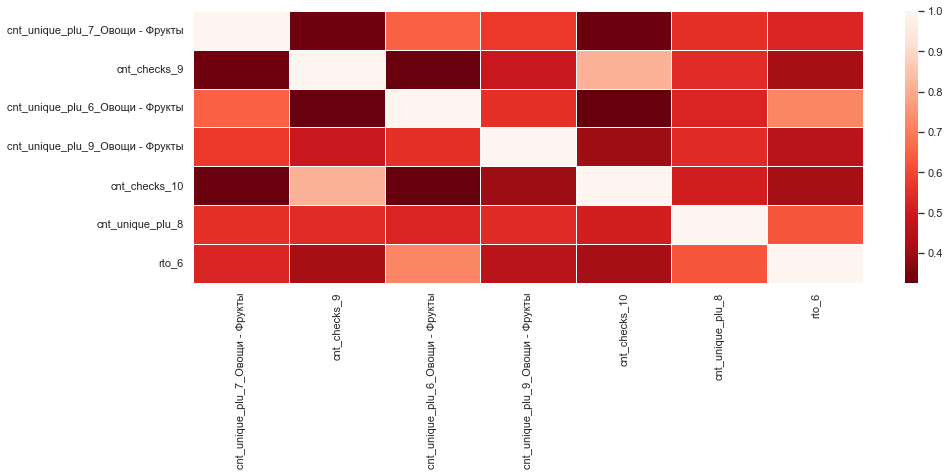

In [ ]:
corr = train_data[cols_cor_matrix[13:20]].corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='Reds_r', linewidths=.5)

Функция для удаления коррелирующих фич

In [49]:
def drop_cor_features(data, correlated_features):
    for features in correlated_features:
        try:
            data.drop(features[0], axis=1, inplace=True)
        except:
            continue

In [50]:
corr_features = correlated_features(train_data)

In [51]:
drop_cor_features(train_data, corr_features) # удаляем из тренировочного набора
drop_cor_features(test_data, corr_features) # из теста удаляем те же фичи, чтобы сохранить размерность

In [ ]:
print(train_data.shape)
print(test_data.shape)

(93596, 106)
(40519, 106)


In [ ]:
len(correlated_features(train_data)) == 0

True

**На этом этапе мы избавились от 27 коррелирующих фич, далее - понижение размерности за счет отбора наиболее значимых фич**

### Отбор наиболее значимых фич [гипотеза 2]

Для оценки значимоти фич мы используем стандарт - критерий Фишера – один из наиболее широко используемых методов контролируемого выбора признаков

Алгоритм, который мы будем использовать, возвращает ранги переменных на основе оценки критерия в порядке убывания, после чего уже следует их отбор

In [52]:
# порог в топ 80% процентов фич дает лучший результат

selector = SelectPercentile(f_classif, percentile=80)
selector.fit(train_data, train_labels)
important_columns = selector.get_feature_names_out()

In [53]:
train_data = train_data[important_columns]
test_data = test_data[important_columns]

In [ ]:
print(train_data.shape)
print(test_data.shape)

(93596, 84)
(40519, 84)


В результате обработке шума в данных мы избавились от коррелирующих и незначимых признаков 

**Итоговая размерность сократась на 62 фичи от изначального количества или на 43 от количества фич после первоначальной обработки фич, что дало ощутимую прибавку в метриках**

## В ходе дополнительной обработки мы проработали две гипотезы:

1.   Удаление шума (аномалии и отрицательные значения) в данных повысит качество модели
2.   Удаление шума (коррелирующие и малозначимые признаки) в признаках повысит качество модели

Оценить влияние каждой гипотезы на улучшение бэйзлайновой модели затруднительно, поскольку аномалии и коррелирующие признаки мы обрабатывали уже в бейзлайне, тогда оба шага оказали равнозначно высокое положительное влияние на результаты

Если говорить про новые шаги, то отдельное влияние замены отрицательных значений на повышение показателей бейзлайновой модели мало - около 5% от общей прибавки, замена алгоритма отбора выбросов - тоже около 5%, а вот отбор фич дал около 80% от результата, остальные 10% роста дали дополнительные данные

## Обучение и оценка результатов

Мы будем дорабатывать модель, которую использовали в бэйзлайне - LightGBM Classifier - эффективную реализацию градиентного бустинга

К плюсам можно отнести:

1.   Большой выбор гиперпараметров и встроенных возможностей
2.   Высокую эффективность по скорости 
и потребляемым ресурсам
3.   Простоту масштабирование от эксперимента до продакшена

К минусам можно отнести:

4.   Склонность к переобучению


Создадим основу для кросс-валидации и оценки модели по основным метрикам

In [54]:
# Модель машинного обучения
model_classes = [LGBMClassifier()]

model_names = ['LGBMClassifier']

# Метрики оценки качества модели
metrics = {'F1_Score':f1_score, 'Precision': precision_score, 'Recall': recall_score}

# Гиперпараметры для GS
# значения в этих диапазонах показывают лучший баланс результатов
parameters_lgb = [{'GS_CV_lgb__n_estimators': [250, 290], 
                   'GS_CV_lgb__num_leaves': [45, 54], 
                   'GS_CV_lgb__max_depth': [10, 17], 
                   'GS_CV_lgb__random_state': [0], 
                   'GS_CV_lgb__is_unbalance': [True],
                   'GS_CV_lgb__min_split_gain': [0],
                   'GS_CV_lgb__reg_alph':[0.8]}]

Основные настраиваемые параметры:

- n_estimators - параметр управляет количеством итераций бустинга, которые будут выполняться
- num_leaves - максимальное количество листьев у дерева
- max_depth - глубина дерева
- random_state - управление используемым генератором случайных чисел
- is_unbalance - параметр, указывающий на несбалансированность данных
- min_split_gain - минимальное уменьшение потерь, необходимое для создания дополнительного раздела на конечном узле дерева
- importance_type - тип заполняемой важности объекта ("split" - количество раз, когда функция используется в модели) 
- reg_alph - Регуляризация L1 для весов. Она добавляет штраф L1, равный абсолютному значению величины коэффициента, или просто ограничивает размер коэффициентов. Регуляризация L1 является предпочтительным выбором при наличии большого количества функций, поскольку она обеспечивает разреженные решения

Проводить нормализацию данных нет необходимости, так алгоритмы на основе решающих деревьев нечувствительны к абсолютным значениям признаков. Они оперируют только порядковым расположением значений. Нормализация используется в линейных моделях / KNN / нейронных сетях, поскольку на них влияют абсолютные значения


Функция вычисления метрик

In [55]:
def calculate_metrics(test_labels, predict_labels, metrics={}):
    if len(metrics) == 0:
        raise ValueError('metrics are empty')
        
    results = dict()
    for key in metrics:
        results[key] = metrics[key](test_labels, predict_labels, average='weighted')
    
    return results

Настройка гиперпараметров

In [ ]:
pipeline = Pipeline([('GS_CV_lgb', LGBMClassifier())])
    
grid_search = GridSearchCV(pipeline, param_grid=parameters_lgb, cv=5, scoring="f1_weighted")
best_clf_lgb = grid_search.fit(train_data, train_labels)

print(grid_search.best_estimator_)

Pipeline(steps=[('GS_CV_lgb',
                 LGBMClassifier(is_unbalance=True, max_depth=17,
                                min_split_gain=0, n_estimators=290,
                                num_leaves=54, random_state=0, reg_alph=0.8))])


Теперь обучим модель на лучших гиперпараметрах по мнению GS_CV

In [56]:
model = LGBMClassifier(n_estimators=288, num_leaves=54, max_depth=17, random_state=0, is_unbalance=True,
                       min_split_gain=0, importance_type='split', reg_alpha=0.8)

In [57]:
start_time = time.time()
model.fit(train_data, train_labels)
print("--- %s seconds ---" % (time.time() - start_time))

--- 14.30630612373352 seconds ---


In [58]:
predict_labels_lgb = model.predict(test_data)

In [59]:
res_lgb = calculate_metrics(test_labels, predict_labels_lgb, metrics=metrics)  

In [60]:
round(accuracy_score(test_labels, predict_labels_lgb), 2)

0.85

In [61]:
res_lgb

{'F1_Score': 0.8684347378013665,
 'Precision': 0.8918275278474161,
 'Recall': 0.8496754608948888}

In [62]:
(predict_labels_lgb == 1).sum()

5164

При подборе гиперпараметров и оценки качества работы модели, мы ориентируемся не только на показатели основных метрик (мы получали результаты значительнов выше), но и на адекватное значение получаемых положительных лейблов, поскольку конечная задача - привлечение новых участников 

## Визуализация результатов работы модели

Создание палитры цветов для графиков

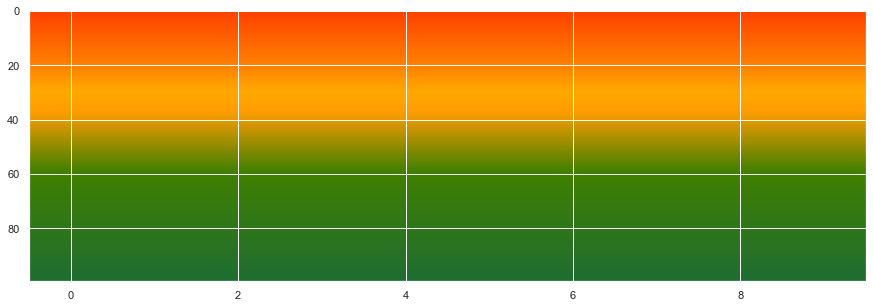

In [ ]:
plt.figure()
a=np.outer(np.arange(0,1,0.01),np.ones(10))
fact = 1.25/255.0
cdict2 = {'red':  [(0.0,   204*fact,  204*fact),
                   (0.2, 255*fact, 255*fact),
                   (0.3,  255*fact, 255*fact),
                   (0.6, 51*fact, 51*fact),
                   (1.0,   25*fact,  25*fact)],
         'green': [(0.0,   51*fact,  51*fact),
                   (0.2, 103*fact, 103*fact),
                   (0.3,  134*fact, 134*fact),
                   (0.6, 102*fact, 102*fact),
                   (1.0,   88*fact,  88*fact)],
         'blue':  [(0.0,  0*fact, 0*fact),
                   (0.2, 0*fact, 0*fact),
                   (0.3,  0*fact, 0*fact),
                   (0.6, 0*fact, 0*fact),
                   (1.0,   40*fact,  40*fact)]} 
my_cmap2 = matplotlib.colors.LinearSegmentedColormap('my_colormap2',cdict2,256)
plt.imshow(a,aspect='auto', cmap =my_cmap2)                   
plt.show()

Теперь можно переходить в созданию графиков

In [ ]:
explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(50)
features = test_data.iloc[select]
features_display = train_data.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

Explainer expected value: [-0.87628175]


Обзор наиболее важных функций модели для каждого образца и влияние каждой функции на выход модели с использованием метрики SHAP value

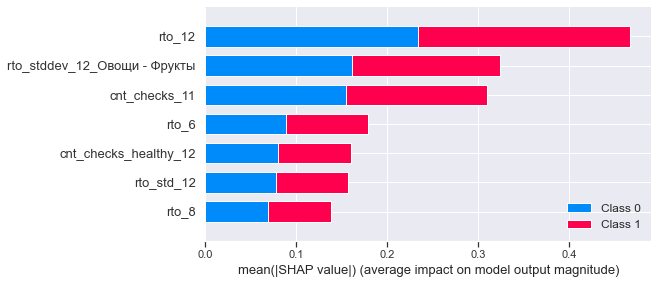

In [ ]:
sum_plot = explainer.shap_values(train_data)
shap.summary_plot(sum_plot, train_data, max_display=7)

График принятия решений по тестовым наблюдениям представлен ниже

* Ось x представляет выходные данные модели. В этом случае единицами являются логарифмические коэффициенты
* График центрируется по оси x в explainer.expected_value. Все значения SHAP относятся к ожидаемому значению модели, как эффекты линейной модели относятся к перехвату
* На оси Y перечислены функции модели. По умолчанию объекты упорядочены по убыванию важности. Важность вычисляется по построенным наблюдениям. _Это обычно отличается от порядка важности для всего набора данных._ Помимо упорядочения важности объектов, график принятия решений также поддерживает иерархическое упорядочение объектов кластера и упорядочение объектов, определяемое пользователем
* Предсказание каждого наблюдения представлено цветной линией. В верхней части графика каждая линия попадает на ось x при соответствующем прогнозируемом значении наблюдения. Это значение определяет цвет линии в спектре
* Перемещаясь от нижней части графика к верхней, значения SHAP для каждого объекта добавляются к базовому значению модели. Это показывает, как каждая функция вносит вклад в общий прогноз
* В нижней части графика наблюдения сходятся в explainer.expected_value
* link='logit' преобразование логарифмических коэффициентов в вероятности
* Наблюдения могут быть выделены с помощью стиля пунктирной линии. Здесь мы выделяем неправильно классифицированное наблюдение

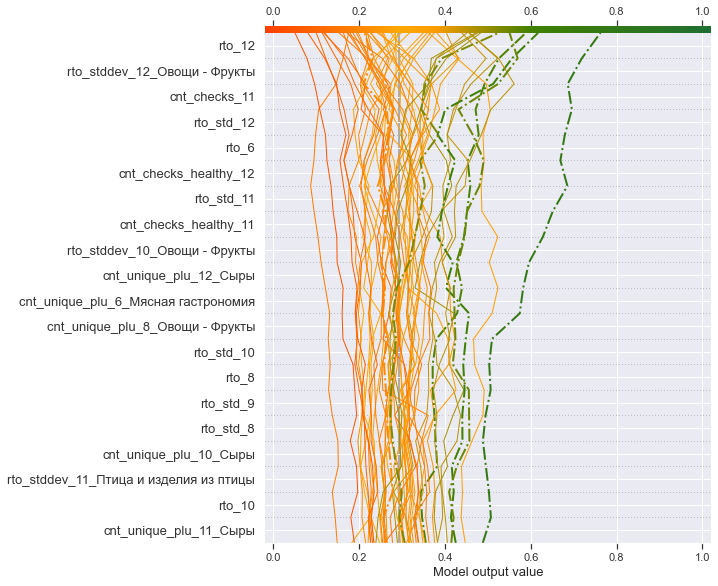

In [ ]:
# Точка отсечения равна нулю логарифмических шансов (вероятность 0,5).
y_pred = (shap_values.sum(1) + expected_value) > 0
misclassified = y_pred != test_labels.iloc[select]
shap.decision_plot(expected_value, shap_values, features_display, link='logit', highlight=misclassified, plot_color=my_cmap2)

Следующий формат графика принятия решений может отображать влияние функций на конкретного покупателя

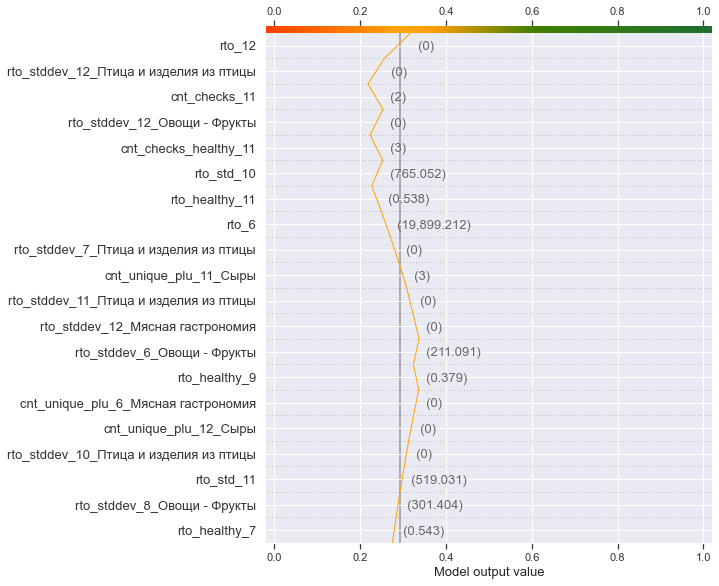

In [ ]:
shap.decision_plot(expected_value, shap_values[1], features_display.iloc[1], link='logit', plot_color=my_cmap2)

## Доразметка полученных результатов механизмами взаимодействия

Еще раз загрузим данные и проведем аналогичную обработку признаков, чтобы соотвествовать размерности обученной модели, заполним нули и негативные значения

In [64]:
data = pd.read_csv('Cup_IT_2022_Data_Science_dataset_final.csv', index_col=0)
data_additional = pd.read_csv('Cup_IT_2022_Data_Science_additional_data.csv', index_col=0)

data_additional.rename(columns={"index": "client_id"}, inplace=True)

data = data.merge(data_additional, on="client_id")

data.set_index('client_id', inplace=True)

In [65]:
features = data.columns

In [66]:
data = new_feature(data, prefix='rto_')
data = new_feature(data, prefix='cnt_checks_')

In [67]:
data.shape[1]

127

In [68]:
drop_cor_features(data, corr_features) # удаляем аналогичные незначимые фичи

In [69]:
data.shape[1]

107

In [70]:
data = data[np.append(important_columns, 'is_in_club')] # выбираем аналогичные значимые фичи

In [71]:
data.shape[1]

85

In [72]:
data = data.fillna(0)

In [73]:
data[data < 0] = np.NaN

data = pd.DataFrame(SimpleImputer(missing_values=np.NaN, strategy='most_frequent').fit_transform(data), columns=data.columns)

Разбиваем данные на тех кто уже в клубе и кто еще нет, нам интересны вторые

In [74]:
data_in_club = data[data['is_in_club'] == 1]

In [75]:
data_not_in = data[data['is_in_club'] == 0]

In [76]:
data_not_in = data_not_in.drop('is_in_club', 1)

In [77]:
data_not_in.shape

(122643, 84)

Теперь воспользуемся нашей моделью для предсказния потенциальных участников клуба

In [78]:
new_clients_club = model.predict(data_not_in)

In [79]:
new_clients_club.shape

(122643,)

In [80]:
data_not_in['new_clients'] = new_clients_club

In [81]:
data_not_in.shape

(122643, 85)

In [82]:
data_pred_pos = data_not_in[data_not_in['new_clients'] == 1]

In [83]:
data_pred_pos.shape[0] # количество человек для коммуникации

13102

Проанализируем нашу целеву аудиторию, попробуем выделить в ней кластеры и описать их (лучше всего сработало n=5)

In [84]:
scaler = StandardScaler()

data_pred_pos_scaled = scaler.fit_transform(data_pred_pos.drop('new_clients', 1))

In [85]:
km = KMeans(n_clusters=5, max_iter=250)
km.fit(data_pred_pos_scaled)

centroids = km.cluster_centers_

Посчитаем количество человек в каждом кластере

In [86]:
np.unique(km.labels_, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32), array([2559,  798, 3773, 3708, 2264]))

In [87]:
centroids_inv = scaler.inverse_transform(centroids)

In [88]:
centroids_df = pd.DataFrame(centroids_inv, columns=data_pred_pos.drop('new_clients', 1).columns)

In [89]:
centroids_df_6 = centroids_df[['rto_6', 'cnt_checks_6', 'rto_std_6', 'rto_stddev_6_Овощи - Фрукты', 'rto_stddev_6_Сыры', 'rto_stddev_6_Птица и изделия из птицы', 'rto_stddev_6_Птица и изделия из птицы', 'cnt_unique_plu_6_Мясная гастрономия', 'cnt_unique_plu_6_Птица и изделия из птицы', 'cnt_unique_plu_6_Крупы и зерновые', 'cnt_unique_plu_6_Сыры', 'rto_healthy_6']] # рассмотрим на примере обного месяца

In [90]:
centroids_df_6

,rto_6,cnt_checks_6,rto_std_6,rto_stddev_6_Овощи - Фрукты,rto_stddev_6_Сыры,rto_stddev_6_Птица и изделия из птицы,rto_stddev_6_Птица и изделия из птицы,cnt_unique_plu_6_Мясная гастрономия,cnt_unique_plu_6_Птица и изделия из птицы,cnt_unique_plu_6_Крупы и зерновые,cnt_unique_plu_6_Сыры,rto_healthy_6
0,10838.991140,16.007034,566.046029,51.021826,36.595053,29.607966,29.607966,2.563892,1.587339,0.563892,2.631497,0.249843
1,23183.357404,18.107769,1164.377283,72.974638,77.727834,77.912918,77.912918,5.550125,3.429825,1.216792,5.561404,0.313741
2,2838.070810,6.234437,255.211938,23.192969,8.058098,5.008346,5.008346,0.459868,0.342781,0.177483,0.691656,0.168270
3,5272.226852,7.238532,486.743634,52.368430,30.263754,15.103334,15.103334,1.050189,0.863195,0.394765,1.907447,0.367953
4,9084.564392,7.092756,792.178977,55.360713,43.705150,38.824052,38.824052,1.986307,1.957597,0.775618,2.697438,0.333566


Рассмотрим центроиды поближе:

0. Это клиенты, которые с боольшой вероятностью придерживаются здорового питания, ведь из всех центроид - у них самая большая доля полезных продуктов в чеках. При том они покупают достаточно немного, нечасто, но с большой для таких чеков вариативностью. Они точно подвержены акциям, предложениям и полезным привычкам, пригласим их в клуб

1. Покупатели из этого кластера знают что им нужно, они приходят за конкретными товарами, но в целом покупат очень скромно. Постараемся расшевелить их акциями на любимые ими продукты

2. Это хорошие покупатели, берут больше среднего, иногда выполняют условия кешбека и судя по std подвержены спонтанным покупкам. Пригласим в клуб и постараемся простимулировать дальнейшее поведение онусами

3. Клиенты этой группы имеют значительно высокие показатели по еолисечтву, объему и вариативности покупок. Мы заинтересованы в них, а они в нас, отправим приглашение

4. Эти люди очень походи на самый первй кластер, покупают небольшими суммами, скорее всего в основном самые нужные конкретные товары. Но, в отличие от первых, их доля здоровых товаров от суммы покупок на 30% ниже. Начнем с акции на лбимый продукт или подкатегорию, а дальше посмотрим на отклик - разберемся

Доразметим центроиды

In [91]:
centroids_df_6['method'] = ['приглашение', 'акция', 'приглашение', 'приглашение', 'акция']

In [92]:
centroids_df_6[['rto_6', 'cnt_checks_6', 'rto_std_6', 'rto_healthy_6', 'method']].reset_index(drop=True)

,rto_6,cnt_checks_6,rto_std_6,rto_healthy_6,method
0,10838.991140,16.007034,566.046029,0.249843,приглашение
1,23183.357404,18.107769,1164.377283,0.313741,акция
2,2838.070810,6.234437,255.211938,0.168270,приглашение
3,5272.226852,7.238532,486.743634,0.367953,приглашение
4,9084.564392,7.092756,792.178977,0.333566,акция


Теперь разметим остальных участников кластеров

In [93]:
km.labels_.shape

(13102,)

In [94]:
data_pred_pos.shape

(13102, 85)

Теперь соедим все данные вместе

In [95]:
data_pred_pos['method'] = km.labels_
data_pred_pos['is_in_club'] = 0

In [96]:
data_not_in.shape

(122643, 85)

In [97]:
data_not_in = data_not_in[data_not_in['new_clients'] == 0]

In [98]:
data_not_in['method'] = ''
data_not_in['is_in_club'] = 0

In [99]:
data_in_club.shape

(12418, 85)

In [100]:
data_in_club['method'] = ''
data_in_club['new_clients'] = 0

In [101]:
df_union = pd.concat([data_not_in, data_in_club], ignore_index=True)

In [102]:
df_union.shape

(121959, 87)

In [103]:
df_union = pd.concat([df_union, data_pred_pos], ignore_index=True)

In [104]:
df_union.shape[0] # кол-во строк соответствует исходному набору

135061

In [105]:
df_union[df_union['is_in_club'] == 1].shape[0] # кол-во изначально положительных лейблов соответствует исходному набору

12418

## Выгрузка результатов

В итоге у нас получился размеченный механизмами взаимодействия набор данных в .csv и обученная модель в формате .pickle

In [106]:
df_union.to_csv("CupIT2022—DS—One-Zero-output_data.csv", index=False)

In [63]:
path = 'CupIT2022-DS-One-Zero-learning_model-LGBMClassifier.pickle'
with open(path, 'wb') as file:
    pickle.dump(model, file)

### Подгрузка файла .pickle с обученной моделью

In [ ]:
!gdown --id 1YUH0omGK-t_KKFBCIyb4DPCDtZcwwDZp
!gdown --id 1magv8pEQHuOOr19vMv93nfluxER5aX-c

d:\ds_it\anaconda\lib\site-packages\gdown\cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1YUH0omGK-t_KKFBCIyb4DPCDtZcwwDZp
To: C:\Users\Nina\Соревнования\Cup IT\Финал\Cup_IT_2022_Data_Science_One-Zero_output_dataset.csv

  0%|          | 0.00/95.9M [00:00<?, ?B/s]
  1%|          | 524k/95.9M [00:00<00:20, 4.73MB/s]
  2%|1         | 1.57M/95.9M [00:00<00:13, 6.86MB/s]
  3%|2         | 2.62M/95.9M [00:00<00:14, 6.66MB/s]
  4%|3         | 3.67M/95.9M [00:00<00:13, 7.03MB/s]
  5%|4         | 4.72M/95.9M [00:00<00:14, 6.34MB/s]
  6%|6         | 5.77M/95.9M [00:00<00:14, 6.39MB/s]
  7%|7         | 6.82M/95.9M [00:01<00:12, 6.91MB/s]
  8%|8         | 7.86M/95.9M [00:01<00:11, 7.69MB/s]
  9%|9         | 8.91M/95.9M [00:01<00:10, 8.29MB/s]
 11%|#         | 10.5M/95.9M [00:01<00:09, 9.48MB/s]
 13%|#2        | 12.1M/95.9M [0

Access denied with the following error:


d:\ds_it\anaconda\lib\site-packages\gdown\cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1magv8pEQHuOOr19vMv93nfluxER5aX-c 



In [ ]:
path = 'CupIT2022-DS-One-Zero-learning_model-LGBMClassifier.pickle'
with open(path, 'rb') as file:
    model = pickle.load(file)

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("CupIT2022—DS—One-Zero-output_data.csv")

## Над кейсом работала команда *One-Zero*:

1.   Мичурин Артём - amichurin0@gmail.ru
2.   Исаева Диана - dii.grase@yandex.ru
3.   Попова Нина - popovaninam@yandex.ru
4.   Агишев Владимир - agishev1961@gmail.com